# Day 19

## Part 1

- to crack geodes we need geode-cracking obsidian robots
- to get obsidian we need robots water-proofed with clay
- to get clay we need clay-collecting robots
- all robots need ore, which is gathered by ore-collecitng robots (with big drills)
- I have one of those ore-collecing robots already!
- robots can collect 1 unit of resource per minute
- it takes 1 minute to build a robot but resourses are consumed the instant the robot construction begins
- we have to choose a blueprint (from the input) and stick with it for the run
- a blueprint's quality is its ID number times the number of geodes we can mine using it in `24 minutes`

` What do you get if you add up the quality level of all of the blueprints in your list?`

In [160]:
from __future__ import annotations

from copy import deepcopy
from dataclasses import dataclass
from matplotlib import pyplot as plt
from utils import parse_from_file, ParseConfig

@dataclass
class Robot:
    ore: int

@dataclass
class OreRobot(Robot):
    pass

@dataclass
class ClayRobot(Robot):
    pass

@dataclass
class ObsidianRobot(Robot):
    clay: int

@dataclass
class GeodeRobot(Robot):
    obsidian: int

@dataclass
class Blueprint:
    id: int
    ore_bot: OreRobot
    clay_bot: ClayRobot
    obsidian_bot: ObsidianRobot
    geode_bot: GeodeRobot
    quality: int = 0

parser = ParseConfig('\n', ParseConfig(': ', [
    ParseConfig(' ', [None, int]),
    ParseConfig('.', [
        ParseConfig(' ', [None]*4 + [int] + [None]),
        ParseConfig(' ', [None]*5 + [int] + [None]),
        ParseConfig(' ', [None]*5 + [int] + [None]*2 + [int] + [None]),
        ParseConfig(' ', [None]*5 + [int] + [None]*2 + [int] + [None]),
        None
    ])
]))

blueprint_values = parse_from_file(
        'day_19.txt', parser, unnest_single_items=True)

blueprints = []
for id, (ore, clay, obsidian, geode) in blueprint_values:
    blueprints.append(Blueprint(
        id,
        OreRobot(ore),
        ClayRobot(clay),
        ObsidianRobot(*obsidian),
        GeodeRobot(*geode)
    ))

print(blueprints[0])

Blueprint(id=1, ore_bot=OreRobot(ore=4), clay_bot=ClayRobot(ore=4), obsidian_bot=ObsidianRobot(ore=4, clay=8), geode_bot=GeodeRobot(ore=2, obsidian=18), quality=0)


In [161]:
@dataclass
class State:
    ore: int
    clay: int
    obsidian: int
    geodes: int
    ore_bots: int
    clay_bots: int
    obsidian_bots: int
    geode_bots: int

    @property
    def hashable(self) -> tuple[int]:
        return self.ore, self.clay, self.obsidian, self.geodes, \
            self.ore_bots, self.clay_bots, self.obsidian_bots, self.geode_bots
    
    def harvest(self) -> None:
        """
        updates the resource values
        """
        self.ore += self.ore_bots
        self.clay += self.clay_bots
        self.obsidian += self.obsidian_bots
        self.geodes += self.geode_bots

    def build(self, robot: Robot|None) -> State:
        """
        returns a copy of this state with the resources required to build
        that robot consumed
        """
        temp = State(*self.hashable)
        if robot is None:
            pass
        elif isinstance(robot, OreRobot):
            temp.ore -= robot.ore
        elif isinstance(robot, ClayRobot):
            temp.ore -= robot.ore
        elif isinstance(robot, ObsidianRobot):
            temp.ore -= robot.ore
            temp.clay -= robot.clay
        elif isinstance(robot, GeodeRobot):
            temp.ore -= robot.ore
            temp.obsidian -= robot.obsidian
        else:
            raise ValueError(f'robot type not recongised: {robot}')
        
        return temp

    def get_options(self, blueprint: Blueprint) -> list[State]:
        """
        returns a list of possible states for a given blueprint
        """
        options = []
        # build nothing
        temp = self.build(None)
        temp.harvest()
        options.append(temp)
        # build an ore bot
        robot = blueprint.ore_bot
        if self.ore >= robot.ore:
            temp = self.build(robot)
            temp.harvest()
            temp.ore_bots += 1
            options.append(temp)
        # build a clay bot
        robot = blueprint.clay_bot
        if self.ore >= robot.ore:
            temp = self.build(robot)
            temp.harvest()
            temp.clay_bots += 1
            options.append(temp)
        # build an obsidian bot
        robot = blueprint.obsidian_bot
        if self.ore >= robot.ore and self.clay >= robot.clay:
            temp = self.build(robot)
            temp.harvest()
            temp.obsidian_bots += 1
            options.append(temp)
        # bulid a geode bot
        robot = blueprint.geode_bot
        if self.ore >= robot.ore and self.obsidian >= robot.obsidian:
            temp = self.build(robot)
            temp.harvest()
            temp.geode_bots += 1
            options.append(temp)

        return options

    def max_geodes(self, time_remaining: int) -> int:
        """
        calculates the maximum possible number of geodes that could be
        harvested in the remaining time

        assumes that it is possible to gather enough resources to create a
        geode bot every minute until the end giving a linearly ramping total
        """
        geodes = self.geodes
        potential_bots = self.geode_bots
        for _ in range(time_remaining + 1):
            geodes += potential_bots
            potential_bots += 1
        return geodes
    
    def max_obsidian(self, time_remaining: int) -> int:
        """
        as max geodes but for obsidian
        """
        obsidian = self.obsidian
        potential_bots = self.obsidian_bots
        for _ in range(time_remaining + 1):
            obsidian += potential_bots
            potential_bots += 1
        return obsidian

start = State(0, 0, 0, 0, 1, 0, 0, 0)

def get_layers(
    start: State, blueprint: Blueprint, total_time: int
) -> list[list[State]]:
    """
    returns a list of all possible states at each iteration
    """
    layers = [[start.hashable]]
    for iteration in range(1, total_time + 1):
        print(
            f'iteration: {iteration}, layer size: {len(layers[-1])}' + ' '*10,
            end='\r'
        )
        time_remamining = total_time - iteration
        new_states = []
        # get all possible subsequent state options
        for values in layers[-1]:
            new_states.extend(State(*values).get_options(blueprint))
        # determine the maximum possible number of geodes from this layer
        total_geode_bots = sum([state.geode_bots for state in new_states])
        if total_geode_bots > 0:
            max_resource = max([
                state.max_geodes(time_remamining)
                for state in new_states
            ])
            resource = 'geodes'
        else:
            max_resource = max([
                state.max_obsidian(time_remamining)
                for state in new_states
            ])
            resource = 'obsidian'
        max_resource *= 0.8
        # add only non duplicates that could still turn out to be optimal
        new_layer = []
        for state in new_states:
            if state.hashable in new_layer:
                continue
            match resource:
                case 'geodes':
                    if state.max_geodes(time_remamining) < max_resource:
                        continue
                case 'obsidian':
                    if state.max_obsidian(time_remamining) < max_resource:
                        continue 
            new_layer.append(state.hashable)
        layers.append(new_layer)
    return [[State(*state) for state in layer] for layer in layers]

In [162]:
blueprint_layers = []

for blueprint in blueprints:
    layers = get_layers(start, blueprint, 24)
    blueprint_layers.append(layers)
    max_geodes = max([state.geodes for state in layers[-1]])
    blueprint.quality = max_geodes * blueprint.id

In [163]:
total_quality = sum([blueprint.quality for blueprint in blueprints])

print(f'the total quality of all blueprints: {total_quality}')

the total quality of all blueprints: 2341


Text(0.5, 0, 'elapsed time / mins')

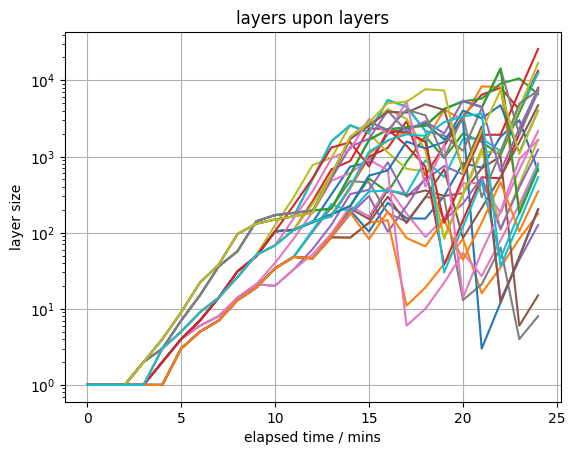

In [204]:
fig, ax = plt.subplots()
for layers in blueprint_layers:
    ax.semilogy(
        list(range(24 + 1)),
        [len(layer) for layer in layers]
    )
ax.grid('ON')
ax.set_title('layers upon layers')
ax.set_ylabel('layer size')
ax.set_xlabel('elapsed time / mins')